# Use `ocetrac-unstruct` to identify and track marine heatwaves
This example using 40 years of Daily outputs at 5km native grid resolution takes ~45 minutes on 512 cores.

In [1]:
import xarray as xr
import numpy as np
import dask
import ocetrac_unstruct

from tempfile import TemporaryDirectory
from getpass import getuser
from pathlib import Path
from dask_jobqueue import SLURMCluster
from dask.distributed import Client, LocalCluster
import subprocess
import re

# import warnings
# warnings.filterwarnings('ignore')

In [2]:
scratch_dir = Path('/scratch') / getuser()[0] / getuser() / 'mhws' 

## Start Dask Cluster

In [3]:
cluster_scratch = Path('/scratch') / getuser()[0] / getuser() / 'clients'
dask_tmp_dir = TemporaryDirectory(dir=cluster_scratch)
dask.config.set(temporary_directory=dask_tmp_dir.name)

In [4]:
## GPU Cluster (Local)
cluster = LocalCluster(n_workers=16, threads_per_worker=4)
client = Client(cluster)
#client

remote_node = subprocess.run(['hostname'], capture_output=True, text=True).stdout.strip().split('.')[0]
port = re.search(r':(\d+)/', client.dashboard_link).group(1)
print(f"Forward with Port = {remote_node}:{port}")

client.dashboard_link

Forward with Port = l40143:8787


'http://127.0.0.1:8787/status'

In [5]:
# scale = 256

# ## Distributed Cluster (without GPU)
# clusterDistributed = SLURMCluster(name='dask-cluster',
#                                     cores=16,
#                                     memory='500GB',
#                                     processes=64,  # 2 threads
#                                     interface='ib0',
#                                     queue='compute',
#                                     account='bk1377',
#                                     walltime='00:25:00',
#                                     asynchronous=0,
#                                     job_extra_directives = [f'--constraint=512G --mem=0'],
#                                     log_directory=f'/home/b/{getuser()}/.log_trash',
#                                     local_directory=dask_tmp_dir.name,
#                                     scheduler_options={'dashboard_address': ':8889'})

# clusterDistributed.scale(scale)
# clientDistributed = Client(clusterDistributed)
# remote_node = subprocess.run(['hostname'], capture_output=True, text=True).stdout.strip().split('.')[0]
# port = re.search(r':(\d+)/', clientDistributed.dashboard_link).group(1)
# print(f"Forward Port = {remote_node}:{port}")
# print(f"localhost:{port}/status")

## Load Pre-processed Data
(cf. `01_preprocess_unstruct.ipynb`)

In [6]:
chunk_size = {'time': 4}
time_subset = slice(365*2,-1)  # Skip the first 2 years
ds = xr.open_zarr(str(scratch_dir / '01_preprocess_unstruct.zarr'), chunks={'time': 2, 'ncells': -1}).drop_vars({'decimal_year', 'dayofyear'}).isel(time=time_subset).chunk(chunk_size)

/home/b/b382615/opt/anaconda3/lib/python3.10/site-packages/xarray/core/dataset.py:282: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 2. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


In [7]:
binary_out = ds.features_notrend.drop_vars({'lat','lon'})
binary_out

<xarray.DataArray 'features_notrend' (time: 13148, ncells: 14886338)> Size: 196GB
dask.array<rechunk-merge, shape=(13148, 14886338), dtype=bool, chunksize=(4, 14886338), chunktype=numpy.ndarray>
Coordinates:
  * ncells   (ncells) int64 119MB 0 1 2 3 ... 14886335 14886336 14886337
  * time     (time) datetime64[ns] 105kB 2004-01-01T23:59:00 ... 2039-12-30T2...

In [8]:
mask = ds.mask.drop_vars({'lat','lon'}).compute()

## Run Tracker

In [9]:
# Tracking Parameters
threshold_percentile = 0.95
min_size_quartile = 0.70      # percent   *NB: At 5km (vs ~25km for regridded data, we find many more very small objects!)
radius = 250.0                # km
resolution = 5.0              # km

In [10]:
tracker = ocetrac_unstruct.Tracker(binary_out, scratch_dir=str(scratch_dir / 'ocetrac_unstruct_scratch'), radius=radius, resolution=resolution, min_size_quartile=min_size_quartile, timedim='time', xdim='ncells', neighbours=ds.neighbours, land_mask=mask)

In [ ]:
blobs = tracker.track()

In [ ]:
blobs.labels.attrs

In [ ]:
xr.where(blobs.labels>=0, blobs.labels, np.nan).isel(time=100).pyic.plot(cmap=cm, fpath_tgrid=zarr_fpath_tgrid)

In [11]:
cluster_labels_unique = xr.open_zarr(str(scratch_dir / 'ocetrac_unstruct_scratch' / '02_cluster_labels_unique_2_temp.zarr'), chunks={}).cluster_labels_unique

In [12]:
import pyicon as pyic
zarr_fpath_tgrid = scratch_dir  / f'fpath_tgrid.zarr'

----Start loading pyicon.
----Start loading pyicon.
----Pyicon was loaded successfully.
----Pyicon was loaded successfully.


In [79]:
from matplotlib.colors import ListedColormap
cm = ListedColormap(np.random.random(size=(int(1e3), 3)).tolist())

### TRY WITH 10 times...

In [14]:
cluster_labels_subset = cluster_labels_unique.isel(time=slice(0,200))

In [15]:
def check_overlap(labels_t, labels_next):
    
    valid_mask = labels_t >= 0

    # Create arrays of indices for valid labels
    valid_indices_t = np.nonzero(valid_mask)[0]
    valid_indices_next = valid_indices_t[labels_next[valid_mask] >= 0]
    
    # Replace labels by the size of each cluster
    unique_labels_t, unique_inverse_t, unique_counts_t = np.unique(labels_t, return_inverse=True, return_counts=True)
    unique_labels_next, unique_inverse_next, unique_counts_next = np.unique(labels_next, return_inverse=True, return_counts=True)
    counts_t = unique_counts_t[unique_inverse_t]
    counts_next = unique_counts_next[unique_inverse_next]
    
    # Create pairs of labels and their sizes
    pairs_next = np.stack((labels_t[valid_indices_next], labels_next[valid_indices_next]), axis=1)
    pairs_next_sort = np.sort(pairs_next, axis=1)
    pairs_next_with_counts = np.concatenate((pairs_next_sort, counts_t[valid_indices_next][:,None], counts_next[valid_indices_next][:,None]), axis=1)

    # Sort the pairs and find unique pairs
    pairs_unique, pairs_counts = np.unique(pairs_next_with_counts, axis=0, return_counts=True)
    
    # Determine how much each overlaps (Relative to current and next time)
    overlap_fraction_vs_t = pairs_counts / pairs_unique[:,2]
    overlap_fraction_vs_next = pairs_counts / pairs_unique[:,3]
    
    # Throw out where both fractions are < 0.5...
    discard_pairs = (overlap_fraction_vs_t < 0.25) | (overlap_fraction_vs_next < 0.25)
    pairs_unique_overlap_filter = pairs_unique[~discard_pairs][:,0:2]

    return pairs_unique_overlap_filter.astype(np.int32)

In [16]:
overlap_pairs = xr.apply_ufunc(
                    check_overlap,
                    cluster_labels_subset,
                    cluster_labels_subset.shift(shifts={'time':-1}, fill_value=-1),
                    input_core_dims=[[tracker.xdim], [tracker.xdim]],
                    output_core_dims=[[]],
                    vectorize=True,
                    dask="parallelized",
                    output_dtypes=[object]
                )

overlap_pairs = overlap_pairs.compute()
overlap_pairs_all = np.concatenate(overlap_pairs.values)

In [17]:
from scipy.sparse import coo_matrix, csr_matrix, eye
from scipy.sparse.csgraph import connected_components
from numba import njit, int64, int32, prange

In [18]:
def cluster_time_pairs(overlap_pairs_all):
    # Get unique labels from the overlap pairs
    labels = np.unique(overlap_pairs_all) # 1D sorted unique.
    
    # Create a mapping from labels to indices
    label_to_index = {label: index for index, label in enumerate(labels)}
    
    # Convert overlap pairs to indices
    overlap_pairs_indices = np.array([(label_to_index[pair[0]], label_to_index[pair[1]]) for pair in overlap_pairs_all])
    
    # Create a sparse matrix representation of the graph
    n = len(labels)
    row_indices, col_indices = overlap_pairs_indices.T
    data = np.ones(len(overlap_pairs_indices))
    graph = csr_matrix((data, (row_indices, col_indices)), shape=(n, n))
    
    # Find connected components
    num_components, component_labels = connected_components(csgraph=graph, directed=False, return_labels=True)
    
    # Group labels by their component label
    clusters = [[] for _ in range(num_components)]
    for label, component_label in zip(labels, component_labels):
        clusters[component_label].append(label)
    
    return clusters


In [19]:
equivalent_labels = cluster_time_pairs(overlap_pairs_all)

In [20]:
min_int32 = np.iinfo(np.int32).min
max_label = cluster_labels_subset.max().compute().data
label_to_cluster_index_array = np.full(max_label + 1, min_int32, dtype=np.int32)

# Fill the lookup array with cluster indices
for index, cluster in enumerate(equivalent_labels):
    for label in cluster:
        label_to_cluster_index_array[label] = np.int32(index) # Because these are the connected labels, there are many fewer!

# Find maximum value in label_to_cluster_index_array, and then fill in all the negatives with incremented values
# max_index = np.max(label_to_cluster_index_array)
# label_to_cluster_index_array[label_to_cluster_index_array < 0] = max_index + 1 + np.arange(np.sum(label_to_cluster_index_array < 0), dtype=np.int32)


In [21]:
# NB: **Need to pass da into apply_ufunc, otherwise it doesn't manage the memory correctly with large shared-mem numpy arrays !!!
label_to_cluster_index_array_da = xr.DataArray(label_to_cluster_index_array, dims='label', coords={'label': np.arange(max_label + 1)})

In [22]:
def map_labels_to_indices(block, label_to_cluster_index_array):
    mask = block >= 0
    new_block = np.zeros_like(block, dtype=np.int32)
    new_block[mask] = label_to_cluster_index_array[block[mask]]
    new_block[~mask] = -10
    return new_block

In [23]:
relabeled_unique = xr.apply_ufunc(
            map_labels_to_indices,
            cluster_labels_subset, 
            label_to_cluster_index_array_da,
            input_core_dims=[[tracker.xdim],['label']],
            output_core_dims=[[tracker.xdim]],
            vectorize=True,
            dask="parallelized",
            output_dtypes=[np.int32]
        )

In [24]:
relabeled_unique = relabeled_unique.persist()
relabeled_unique = relabeled_unique + 1

/home/b/b382615/opt/anaconda3/lib/python3.10/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 30.54 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [30]:
relabeled_unique

<xarray.DataArray (time: 200, ncells: 14886338)> Size: 12GB
dask.array<add, shape=(200, 14886338), dtype=int32, chunksize=(4, 14886338), chunktype=numpy.ndarray>
Coordinates:
    lat      (ncells) float64 119MB dask.array<chunksize=(14886338,), meta=np.ndarray>
    lon      (ncells) float64 119MB dask.array<chunksize=(14886338,), meta=np.ndarray>
  * ncells   (ncells) int64 119MB 0 1 2 3 ... 14886335 14886336 14886337
  * time     (time) datetime64[ns] 2kB 2004-01-01T23:59:00 ... 2004-07-18T23:...

In [35]:
relabeled_unique_plotting = xr.where(relabeled_unique >= 0, relabeled_unique, np.nan).persist()

In [43]:
relabeled_unique_plotting

<xarray.DataArray (time: 200, ncells: 14886338)> Size: 24GB
dask.array<where, shape=(200, 14886338), dtype=float64, chunksize=(4, 14886338), chunktype=numpy.ndarray>
Coordinates:
    lat      (ncells) float64 119MB dask.array<chunksize=(14886338,), meta=np.ndarray>
    lon      (ncells) float64 119MB dask.array<chunksize=(14886338,), meta=np.ndarray>
  * ncells   (ncells) int64 119MB 0 1 2 3 ... 14886335 14886336 14886337
  * time     (time) datetime64[ns] 2kB 2004-01-01T23:59:00 ... 2004-07-18T23:...

In [82]:
from matplotlib.colors import LinearSegmentedColormap

def create_float_colormap(num_colors):
    # Generate random RGB colors for each whole number
    colors = np.random.random(size=(num_colors, 3))
    
    # Create a dictionary mapping whole numbers to colors
    color_dict = {i: tuple(colors[i]) for i in range(num_colors)}
    
    # Create a LinearSegmentedColormap using the color dictionary
    cmap = LinearSegmentedColormap.from_list("random_float_colormap", list(color_dict.values()), N=num_colors)
    
    return cmap

# Example usage
num_colors = 1001  # Number of colors (0 to 1000)
float_colormap = create_float_colormap(num_colors)

(<GeoAxes: title={'right': '2004-04-10T23:59:00'}>,
  <matplotlib.colorbar.Colorbar at 0x15468b1b72e0>])

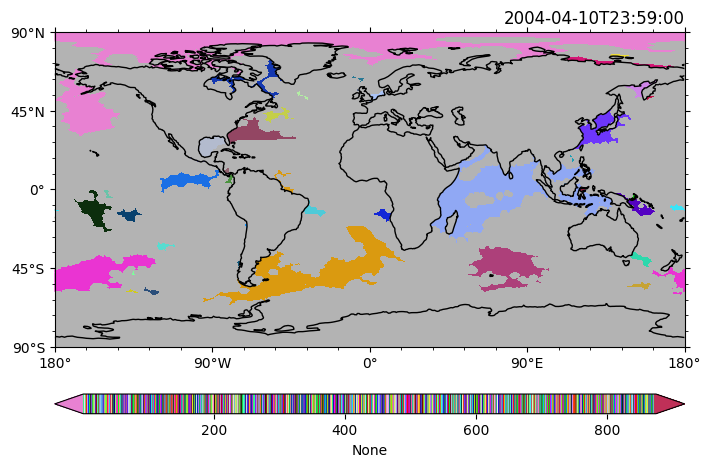

In [83]:
relabeled_unique_plotting.isel(time=100).pyic.plot(cmap=float_colormap, fpath_tgrid=zarr_fpath_tgrid)

(<GeoAxes: title={'right': '2004-04-11T23:59:00'}>,
  <matplotlib.colorbar.Colorbar at 0x15468afef6a0>])

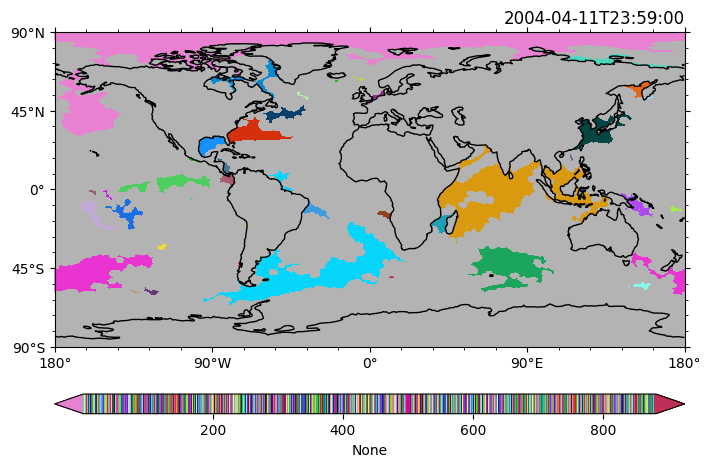

In [84]:
relabeled_unique_plotting.isel(time=101).pyic.plot(cmap=float_colormap, fpath_tgrid=zarr_fpath_tgrid)

(<GeoAxes: title={'right': '2004-04-10T23:59:00'}>,
  <matplotlib.colorbar.Colorbar at 0x1546cb9db7f0>])

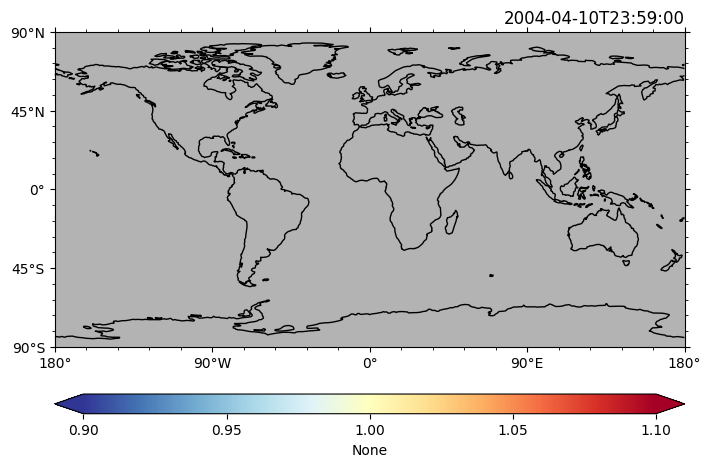

In [90]:
xr.where(relabeled_unique_plotting==875, 1.0, 0.0).isel(time=100).pyic.plot(fpath_tgrid=zarr_fpath_tgrid)

(<GeoAxes: title={'right': '2004-04-11T23:59:00'}>,
  <matplotlib.colorbar.Colorbar at 0x15467c1784c0>])

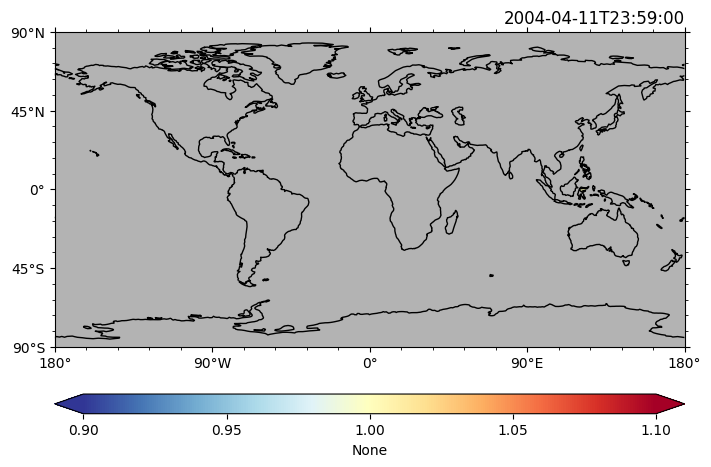

In [89]:
xr.where(relabeled_unique_plotting==875, 1.0, 0.0).isel(time=101).pyic.plot(fpath_tgrid=zarr_fpath_tgrid)

In [88]:
relabeled_unique_plotting

<xarray.DataArray (time: 200, ncells: 14886338)> Size: 24GB
dask.array<where, shape=(200, 14886338), dtype=float64, chunksize=(4, 14886338), chunktype=numpy.ndarray>
Coordinates:
    lat      (ncells) float64 119MB dask.array<chunksize=(14886338,), meta=np.ndarray>
    lon      (ncells) float64 119MB dask.array<chunksize=(14886338,), meta=np.ndarray>
  * ncells   (ncells) int64 119MB 0 1 2 3 ... 14886335 14886336 14886337
  * time     (time) datetime64[ns] 2kB 2004-01-01T23:59:00 ... 2004-07-18T23:...

In [91]:
np.unique(relabeled_unique_plotting.isel(time=100))

array([  1.,  13.,  53., 274., 276., 436., 567., 584., 667., 704., 749.,
       759., 760., 773., 784., 797., 801., 802., 803., 825., 826., 839.,
       850., 852., 857., 858., 860., 861., 862., 863., 864., 865., 866.,
       867., 868., 869., 870., 871., 872., 873., 874., 875.,  nan])

In [85]:
np.unique(relabeled_unique_plotting.isel(time=101))

array([  1.,  13.,  53., 274., 276., 436., 584., 667., 704., 749., 759.,
       760., 773., 784., 797., 801., 802., 803., 825., 826., 839., 850.,
       852., 857., 858., 860., 861., 864., 866., 868., 870., 871., 872.,
       873., 874., 875., 876., 877., 878., 879., 880., 881., 882.,  nan])

2024-10-11 11:08:16,695 - distributed.scheduler - WARNING - Detected different `run_spec` for key 'original-open_dataset-cluster_labels_unique-87064c996a84515a1a61c9c9894198ba' between two consecutive calls to `update_graph`. This can cause failures and deadlocks down the line. Please ensure unique key names. If you are using a standard dask collections, consider releasing all the data before resubmitting another computation. More details and help can be found at https://github.com/dask/dask/issues/9888. 
Debugging information
---------------------
old task state: released
old run_spec: (<function execute_task at 0x1553eb8f51b0>, (ImplicitToExplicitIndexingAdapter(array=CopyOnWriteArray(array=LazilyIndexedArray(array=<xarray.backends.zarr.ZarrArrayWrapper object at 0x154ac93163c0>, key=BasicIndexer((slice(None, None, None), slice(None, None, None)))))),), {})
new run_spec: (<function execute_task at 0x1553eb8f51b0>, (ImplicitToExplicitIndexingAdapter(array=CopyOnWriteArray(array=Lazily

(<GeoAxes: title={'right': '2004-04-10T23:59:00'}>,
  <matplotlib.colorbar.Colorbar at 0x15484b735210>])

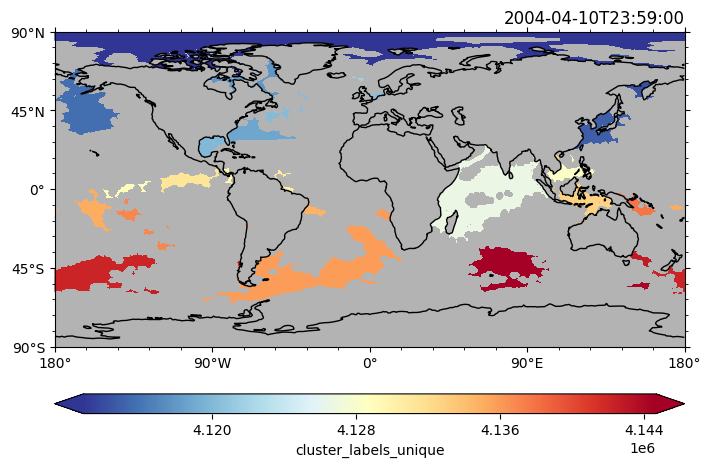

In [28]:
xr.where(cluster_labels_subset>=0, cluster_labels_subset, np.nan).isel(time=100).pyic.plot(fpath_tgrid=zarr_fpath_tgrid)

(<GeoAxes: title={'right': '2004-04-11T23:59:00'}>,
  <matplotlib.colorbar.Colorbar at 0x15484b421bd0>])

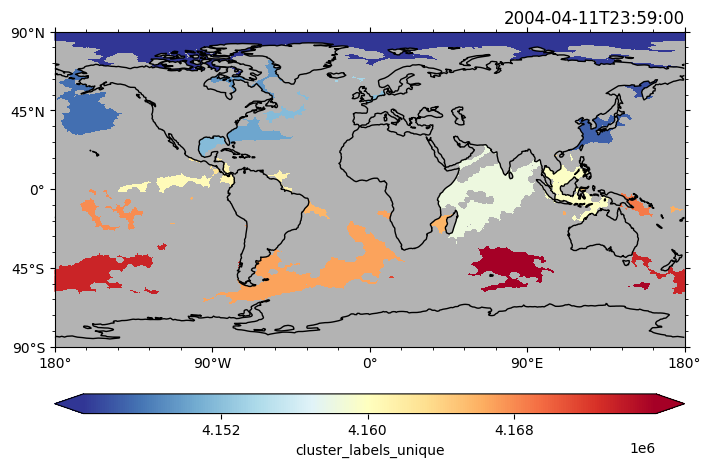

In [29]:
xr.where(cluster_labels_subset>=0, cluster_labels_subset, np.nan).isel(time=101).pyic.plot(fpath_tgrid=zarr_fpath_tgrid)

In [38]:
np.unique(cluster_labels_subset.isel(time=100).compute().data)

array([-9223372036850663314,              4112834,              4113325,
                    4114146,              4114301,              4114699,
                    4114892,              4115225,              4115574,
                    4115749,              4117485,              4117880,
                    4117947,              4118826,              4120151,
                    4120265,              4120267,              4120268,
                    4120451,              4120662,              4121880,
                    4126705,              4128262,              4128286,
                    4128992,              4128993,              4129379,
                    4129608,              4129709,              4130602,
                    4130863,              4131341,              4132673,
                    4132755,              4132919,              4133057,
                    4133793,              4134795,              4135143,
                    4135166,              4135896, 

In [39]:
label_to_cluster_index_array[np.unique(cluster_labels_subset.isel(time=100).compute().data)[1::]]

array([          0,         783,         748, -2147483648,         435,
               583,         862, -2147483648,           0, -2147483648,
               703,         703,         772,         802,         863,
       -2147483648,          12,         801,         864,         870,
               275,         871,         275,         872, -2147483648,
               865,         824,         873,         273,         857,
               849,         866,         275,         874, -2147483648,
       -2147483648,         838,         867,         825,         273,
               759,         796, -2147483648,         856, -2147483648,
               869, -2147483648, -2147483648,         758,         868,
               851,          52,         860,         861,         859,
               566,         800,         666, -2147483648], dtype=int32)

In [40]:
label_to_cluster_index_array[np.unique(cluster_labels_subset.isel(time=101).compute().data)[1::]]

array([          0,         783,         748,         435,         583,
       -2147483648,           0,         703,         703,         772,
               802,         863,          12,         801,         870,
               875,         275,         876,         871,         275,
               849,         865,         824,         873,         273,
               877,         857, -2147483648,         874, -2147483648,
               878,         838,         879, -2147483648,         867,
       -2147483648,         273,         759,         796,         825,
               880,         856,         872,         758, -2147483648,
               881,         851,          52,         869,         860,
               859,         800,         666], dtype=int32)

In [42]:
np.unique(relabeled_unique_plotting.isel(time=100).compute().data)

array([  1.,  13.,  53., 274., 276., 436., 567., 584., 667., 704., 749.,
       759., 760., 773., 784., 797., 801., 802., 803., 825., 826., 839.,
       850., 852., 857., 858., 860., 861., 862., 863., 864., 865., 866.,
       867., 868., 869., 870., 871., 872., 873., 874., 875.,  nan])

In [41]:
np.unique(relabeled_unique_plotting.isel(time=101).compute().data)

array([  1.,  13.,  53., 274., 276., 436., 584., 667., 704., 749., 759.,
       760., 773., 784., 797., 801., 802., 803., 825., 826., 839., 850.,
       852., 857., 858., 860., 861., 864., 866., 868., 870., 871., 872.,
       873., 874., 875., 876., 877., 878., 879., 880., 881., 882.,  nan])

In [13]:
blobs.attrs

In [14]:
# clientDistributed.close()

## Save Blobs
NB: Blobs file is already saved, but just move it into the `scratch_dir`

In [15]:
import shutil
shutil.move(str(scratch_dir / 'ocetrac_unstruct_scratch' / '02_final_labels.zarr'), str(scratch_dir / '02_tracked_unstruct.zarr'))